# Imports and setup

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import os
from os.path import join
import warnings
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dropout, Flatten, RepeatVector, Activation, Concatenate
from tensorflow.keras.layers import Embedding, Conv1D, Conv2D, MaxPooling2D, LSTM, GRU, BatchNormalization, Reshape
from tensorflow.keras.layers import TimeDistributed, Dense, Input, GlobalAveragePooling2D, Bidirectional
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras import models
from tensorflow.keras.models import  Sequential
from tensorflow.keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import PCA


from functools import reduce
from scipy.signal import savgol_filter 
import matplotlib.colors as mcolors


# Functions and classes

In [3]:




def split_dataset(x, y, samples_per_class, n_models, include_classes, to_categorical = False) : 
    datasets = [None]*n_models 
    labels = [None]*n_models 

    sample_indecies = [None]*n_models 
    n_classes = len(original_labels)
    combined_idx = np.array([], dtype = np.int16) 
     
    all_classes = list(np.arange(n_classes))

    for label in all_classes :
        idx = np.where(y == label)[0]
        idx = np.random.choice(idx, samples_per_class*n_models, replace = True) 
        combined_idx = np.r_[combined_idx, idx]
        for i in range(n_models) :
            if include_classes != 'all' : 
                if label not in include_classes[i] :
                    continue
            if datasets[i] is None :
                datasets[i] = [x[idx[i*samples_per_class : (i+1)*samples_per_class]]]
                labels[i] = [y[idx[i*samples_per_class : (i+1)*samples_per_class]]]
            else : 
                datasets[i].append( x[idx[i*samples_per_class : (i+1)*samples_per_class]])
                labels[i].append(y[idx[i*samples_per_class : (i+1)*samples_per_class]])
  
    for i in range(n_models) : 
        datasets[i] = np.concatenate(datasets[i])
        labels[i] = np.concatenate(labels[i])
    

    total_datasets = x[combined_idx]
    total_labels = y[combined_idx]

    
    if to_categorical : 
        for i, l in enumerate(labels): 
            labels[i] = tf.keras.utils.to_categorical(l, num_classes = n_classes)       
        total_labels = tf.keras.utils.to_categorical(total_labels, num_classes = n_classes)
    
    return datasets, labels, total_datasets, total_labels 




def get_data (data_dir, label, as_np = False, as_df = False) : 

    experiments = [] 
    data = [] 
    with open(data_dir, 'r') as f : 
        for line in f.readlines() : 
            if line.startswith('month') : 
                if len(data) : 
                    experiments.append(data) 
                    data = [] 
            data.append(line) 
        if len(data) : 
            experiments.append(data) 
    
    if as_np or as_df : 
        np_exps = [] 
        for i, exp in enumerate(experiments) : 
            _, data = put_experiment_data_to_np(exp, label = label)  
            np_exps.append(data) 
        np_exp = np.concatenate(np_exps) 

        if as_df : 
            dataframe_dict = {
                'hr': np_exp[:, 0],
                'gryo_x': np_exp[:, 1], 
                'gyro_y': np_exp[:, 2], 
                'gyro_z': np_exp[:, 3],
                'timestamp': np_exp[:, 4], 
                'label': np_exp[:, 5]}
            df = pd.DataFrame(dataframe_dict)
            return df 
         
        return np_exp 


    return experiments 



def put_experiment_data_to_np(exp, label = None) : 

    def get_first_hr(exp) : 
        for i in range(1, len(exp)):
            line = exp[i]
            vars = line.split(',') 
            if len(vars) == 2 : 
                return int(vars[0])
    hr = get_first_hr(exp) 
    np_data = []
    for i in range(1, len(exp)):
        line = exp[i]
        vars = line.split(',') 
        if len(vars) == 2 : 
            if (int(vars[0])  < 0) : continue 
            hr = (int(vars[0]) + hr) // 2
        elif len(vars) == 4 : 
            gryo_vars = list(map(int, vars[:3])) 
            if label is not None : 
                data = np.array([hr, *gryo_vars, int(vars[3].split('.')[0]), label])
            else : 
                data = np.array([hr, *gryo_vars, int(vars[3].split('.')[0])])
            np_data.append(data)      
    return exp[0], np.array(np_data) 



def get_models(p, configurations) : 

    learning_rate = p['learning_rate']
    seq_len = p['seq_len']
    n_features = p['n_features']
    n_classes = p['n_classes']

    filters1, filters2, filters3 = configurations['filters']
    lstm_units1, lstm_units2 = configurations['lstm_units']
    ks1, ks2, ks3 = configurations['kernel_size']

    # l2_norm_clip = p['l2_norm_clip']
    # dp_learning_rate = p['dp_learning_rate']
    # batch_size = p['batch_size']
    # num_microbatches = p['num_microbatches']
    # noise_multiplier = p['noise_multiplier']
    # dp_optimizer = p['dp_optimizer']
    # from_logits = p['from_logits']

    # if batch_size % num_microbatches != 0:
    #     raise ValueError('Batch size should be an integer multiple of the number of microbatches')

    K.clear_session() 
    #__________________________Inputs
    inp = Input(shape = (seq_len, n_features))
    #__________________________layers
    conv1 = Conv1D(filters = filters1 , kernel_size = 20, dilation_rate = 2, activation = 'relu')(inp)
    conv2 = Conv1D(filters = filters2 , kernel_size = 20, dilation_rate = 2, activation = 'relu')(conv1)
    conv3 = Conv1D(filters = filters3 , kernel_size = 10, dilation_rate = 2, activation = 'relu')(conv2)
    lstm1 = LSTM(lstm_units1, return_sequences = True, activation = 'tanh')(conv3)
    lstm2 = LSTM(lstm_units2, return_sequences = False, activation = 'tanh')(lstm1) 
    lstm_d = Dropout(0.1)(lstm2)
    dense1 = Dense(10)(lstm_d)
    dense2 = Dense(n_classes)(dense1)
    dense2 = Activation('softmax')(dense2)
    model_A = models.Model(inputs = inp, outputs = dense2)

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    model_A.compile(optimizer= optimizer, loss = loss, metrics = ["accuracy"])
    
    # remove the last layer and compile with a different loss function
    model_B = models.Model(inputs = model_A.inputs, outputs = model_A.layers[-2].output)
    model_B.compile(optimizer = optimizer, loss = "mean_absolute_error")

    return model_A, model_B





def get_label(filename) : 
    filename = filename.split(".")[0]
    if filename.startswith('study') :
        return 0
    elif filename.startswith('walk') : 
        return 1
    elif filename.startswith('sleep') : 
        return 2
    elif filename.startswith('idle') : 
        return 3
    else :
        return -1


In [4]:



def number_of_parameters(model) : 
    return model.count_params()



def get_optimizer(hp) : 
    optimizer_name = hp['optimizer'].lower()
    if optimizer_name == 'adam' :
        return tf.keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    elif optimizer_name == 'sgd' :
        return tf.keras.optimizers.SGD(learning_rate=hp['learning_rate'])
    elif optimizer_name == 'rmsprop' :
        return tf.keras.optimizers.RMSprop(learning_rate=hp['learning_rate'])
    else : 
        raise Exception('Optimizer not supported')


def get_tunable_models(hp) : 
    K.clear_session()
    n_conv_layers = hp['n_conv_layers'] 
    n_lstm_layers = hp['n_lstm_layers']
    activation_function = hp['activation_function']
    dropout_rate = hp['dropout_rate']
    conv_filter = hp['conv_filter']
    conv_kernel_size = hp['conv_kernel_size']
    lstm_units = hp['lstm_units']
    optimizer = get_optimizer(hp)
    learning_rate = hp['learning_rate']
    input_shape = hp['input_shape']

    x = Input(shape = input_shape) 
    y = Reshape(input_shape)(x) 
    for i in range(n_conv_layers) : 
        y = Conv1D(conv_filter, conv_kernel_size, activation = activation_function)(y)
        y = MaxPooling1D(2)(y)
    y = Dropout(dropout_rate)(y)
    for i in range(n_lstm_layers) :
        y = LSTM(lstm_units, return_sequences = True)(y)
    lstm_layer = LSTM(lstm_units, return_sequences = False)(y)
    lstm_dropout_layer = Dropout(dropout_rate)(lstm_layer)
    
    dense = Dense(hp['n_classes'])(lstm_dropout_layer)
    output = Activation('softmax')(dense)
    model1 = tf.keras.models.Model(inputs = x, outputs = output)
    model1.compile(optimizer = optimizer, loss= 'categorical_crossentropy', metrics=['accuracy'])
    model2 = tf.keras.models.Model(inputs = x, outputs = dense)
    model2.compile(optimizer = optimizer, loss= 'mean_absolute_error')

    return model1, model2




class Node : 

    model = None 
    carrier_dataset_metadata = None
    carrier_datset = None

    local_target_dataset = None 
    target_validation_set = None 

    target_validation_acc = []
    target_validation_loss = [] 


    def __init__(self, model, local_target_dataset, shared_public_dataset, target_validation_gen) : 
        self.model = model 
        self.local_target_dataset = local_target_dataset
        self.shared_public_dataset = shared_public_dataset
        self.target_validation_gen = target_validation_gen


    def get_training_metadata(self, seed, alpha) : 

        self.seed = seed 
        self.alpha = alpha
        carrier_preds = self.get_carrier_scores() 
        target_performance = self.evaluate_on_validation_set(save = False)[1]
        data_shape = carrier_preds.shape

        # carrier_preds = from_categorical(carrier_preds) 

        # print("carrier_preds:{}  new_labels:{}".format(carrier_preds.shape, new_labels.shape))
        return carrier_preds, target_performance


    def get_carrier_scores(self) : 
        return self.model[1].predict(self.shared_public_dataset[0], batch_size = 32)


    def receive_training_metadata(self, metadata) : 

        self.update_public_dataset_labels(metadata) 


    def update_public_dataset_labels(self, metadata) : 
        new_shared_public_dataset = (self.shared_public_dataset[0], metadata )
        
        self.shared_public_dataset = new_shared_public_dataset


    def evaluate_on_validation_set(self, save = True) : 
        eval_x, eval_y = self.target_validation_gen
        loss, acc = self.model[0].evaluate(eval_x, eval_y, batch_size = 32, verbose = False)
        if save : 
            self.target_validation_loss.append(loss)
            self.target_validation_acc.append(acc)
        return loss, acc


    def train_on_target(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None, evaluate = False) :
        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])
        
        if evaluate : 
            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], \
                validation_data = self.target_validation_gen, epochs = epochs, callbacks = cbs, verbose = verbose)
        else : 

            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], epochs = epochs, 
                                        callbacks = cbs, verbose = verbose)


    def train_on_public(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None) : 

        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])
        history = self.model[1].fit(self.shared_public_dataset[0], self.shared_public_dataset[1],
         epochs = epochs, callbacks = cbs, verbose = verbose)


    def save_model(self, model_path) : 
        self.model[0].save(model_path + '_classifier.h5') 
        self.model[1].save(model_path + '_regressor.h5') 


def aggregate_training_metadatas(carrier_labels, target_performance, weighted_averaging = False) : 
    
    
    if weighted_averaging : 
        aggregate_training_metadata = np.average(carrier_labels, weights = target_performance, axis = 0)
    else : 
        aggregate_training_metadata = np.average(carrier_labels, axis = 0) 

    return aggregate_training_metadata


def collect_metadatas(nodes, seed, alpha) : 
    # Collect training metadata
    pub_scores, target_performances = [], []
    for i, node in enumerate(nodes) : 
        training_metadata, target_performance = node.get_training_metadata(seed, alpha) 
        pub_scores.append(training_metadata)
        target_performances.append(target_performance) 
    return pub_scores, target_performances 


class FedAMDNode : 

    model = None 
    carrier_dataset_metadata = None
    carrier_datset = None

    local_target_dataset = None 
    target_validation_set = None 

    target_validation_acc = []
    target_validation_loss = [] 


    def __init__(self, model, local_target_dataset, shared_public_dataset, target_validation_gen) : 
        self.model = model 
        self.local_target_dataset = local_target_dataset
        self.shared_public_dataset = shared_public_dataset
        self.target_validation_gen = target_validation_gen


    def get_training_metadata(self, seed, alpha) : 

        self.seed = seed 
        self.alpha = alpha
        carrier_preds = self.get_carrier_scores() 
        target_performance = self.evaluate_on_validation_set(save = False)[1]
        data_shape = carrier_preds.shape

        # carrier_preds = from_categorical(carrier_preds) 

        # print("carrier_preds:{}  new_labels:{}".format(carrier_preds.shape, new_labels.shape))
        return carrier_preds, target_performance


    def get_carrier_scores(self) : 
        
        x = self.shared_public_dataset[0]
        np.random.seed(self.seed) 
        index = np.random.permutation(len(x))  
        mixed_x = self.alpha * x + (1 - self.alpha) * x[index, ...]
    
        return self.model[1].predict(mixed_x, batch_size = 32)


    def receive_training_metadata(self, metadata) : 

        self.update_public_dataset_labels(metadata) 


    def update_public_dataset_labels(self, metadata) : 
        new_shared_public_dataset = (self.shared_public_dataset[0], metadata )
        
        self.shared_public_dataset = new_shared_public_dataset


    def evaluate_on_validation_set(self, save = True) : 
        eval_x, eval_y = self.target_validation_gen
        loss, acc = self.model[0].evaluate(eval_x, eval_y, batch_size = 32, verbose = False)
        if save : 
            self.target_validation_loss.append(loss)
            self.target_validation_acc.append(acc)
        return loss, acc

    def train_on_target(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None, evaluate = False) :
        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])
        if evaluate : 
            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], \
                validation_data = self.target_validation_gen, epochs = epochs, callbacks = cbs, verbose = verbose)
        else : 

            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], epochs = epochs, 
                                        callbacks = cbs, verbose = verbose)


    def train_on_public(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None) : 

        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])
    
        x = self.shared_public_dataset[0]
        np.random.seed(self.seed) 
        index = np.random.permutation(len(x))  
        mixed_x = self.alpha * x + (1 - self.alpha) * x[index, ...]

        history = self.model[1].fit(mixed_x, self.shared_public_dataset[1],
         epochs = epochs, callbacks = cbs, verbose = verbose)



    def save_model(self, model_path) : 
        self.model[0].save(model_path + '_classifier.h5') 
        self.model[1].save(model_path + '_regressor.h5') 




In [5]:
print(np.random.rand())

0.7954026278471467


# Data and models setup

In [6]:
results_dir = 'results'

experiment_dir = os.path.join(results_dir, 'exp_1')
subdirs = ['local_train_iid', 'local_train_noniid', 'central_train_iid', 'central_train_noniid', 'fedMD_iid', 'fedMD_noniid']
# subdirs = ['local_train_iid', 'local_train_noniid', 'central_train_iid', 'central_train_noniid', 'fedAMD_iid', 'fedAMD_noniid']
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)
    for subdir in subdirs : 
        os.makedirs(os.path.join(experiment_dir, subdir))




n_parties = 10
n_samples_per_class = 20

n_alignment =  100
n_iterations = 30 
n_features = 4 
n_classes = 4 
seq_len  = 300 
offset = 50 

learning_rate = 0.000_1





In [7]:

original_labels = ['study', 'walk', 'sleep', 'idle']


data_dir = '../../Data/'


subjects_dirs = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

all_subjects_files = [] 
all_labels = [] 
for subject_dir in subjects_dirs :
    subject_files = [f for f in os.listdir(subject_dir) if f.endswith('.txt') and any(f.startswith(label) for label in original_labels)]
    labels = [get_label(f) for f in subject_files]
    all_subjects_files.extend([os.path.join(subject_dir, f) for f in subject_files])
    all_labels.extend(labels)

print('subject files: ') 
print(all_subjects_files)


data_batches, data_labels = [], []
timestamps = [0] * len(original_labels)
for i in range(len(all_subjects_files)) : 
    data_df = get_data(all_subjects_files[i], as_df = True, label = all_labels[i])
    data_duration = data_df['timestamp'].values[-1] - data_df['timestamp'].values[0]
    timestamps[data_df['label'][0]] += data_duration
    
    data_df, label_df = data_df[['hr', 'gryo_x', 'gyro_y', 'gyro_z']], data_df[['label']]
    data_batches.extend([data_df.iloc[i:i+seq_len] for i in range(0, len(data_df)-seq_len, offset)])
    data_labels.extend([label_df.iloc[i+seq_len] for i in range(0, len(data_df)-seq_len, offset)])


data_batches = np.array(data_batches)
data_labels = np.array(data_labels)
# data_labels = to_categorical(data_labels, num_classes = len(original_labels))

# shuffle data
perm = np.random.permutation(len(data_batches))
data_batches = data_batches[perm]
data_labels = data_labels[perm]


# split data into train and test
train_size = int(len(data_batches) * 0.7)
pub_data_size = int(len(data_batches) * 0.1)
test_size = len(data_batches) - train_size - pub_data_size

train_batches = data_batches[:train_size]
train_labels = data_labels[:train_size]

pub_data_batches = data_batches[train_size:train_size+pub_data_size]
pub_data_labels = data_labels[train_size:train_size+pub_data_size]

test_batches = data_batches[train_size+pub_data_size:]
test_labels = data_labels[train_size+pub_data_size:]


# scaling_data = MinMaxScaler()
# scaled_train_batches = scaling_data.fit_transform(train_batches)
# scaled_pub_batches = scaling_data.transform(pub_data_batches)
# scaled_test_batches = scaling_data.transform(test_batches) 





subject files: 
['../../Data/Aya\\study00.txt', '../../Data/Aya\\study01.txt', '../../Data/Gad\\idle00.txt', '../../Data/Gad\\idle01.txt', '../../Data/Gad\\sleep00.txt', '../../Data/Gad\\study00.txt', '../../Data/Gad\\study01.txt', '../../Data/Gad\\study02.txt', '../../Data/Gad\\study03.txt', '../../Data/Gad\\study04.txt', '../../Data/Gad\\study05.txt', '../../Data/Gad\\study06.txt', '../../Data/Gad\\study07.txt', '../../Data/Gad\\walk00.txt', '../../Data/Gad\\walk01.txt', '../../Data/Gad\\walk02.txt']


# Federated learning

In [82]:
configurations = [{'n_conv_layers': 3, 'n_lstm_layers': 2, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 5, 'lstm_units': 32, 'optimizer': 'Adam', 'learning_rate': 0.0001, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 1, 'n_lstm_layers': 1, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 5, 'lstm_units': 20, 'optimizer': 'Adam', 'learning_rate': 7.000000000000001e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 1, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 20, 'optimizer': 'Adam', 'learning_rate': 4e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 2, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 10, 'conv_kernel_size': 9, 'lstm_units': 32, 'optimizer': 'RMSprop', 'learning_rate': 1e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 2, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 5, 'optimizer': 'RMSprop', 'learning_rate': 7.000000000000001e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 3, 'n_lstm_layers': 3, 'activation_function': 'tanh', 'dropout_rate': 0.1, 'conv_filter': 5, 'conv_kernel_size': 9, 'lstm_units': 32, 'optimizer': 'Adam', 'learning_rate': 0.0001, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 3, 'n_lstm_layers': 1, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 5, 'optimizer': 'RMSprop', 'learning_rate': 1e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 3, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 10, 'conv_kernel_size': 18, 'lstm_units': 5, 'optimizer': 'Adam', 'learning_rate': 1e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 1, 'n_lstm_layers': 3, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 5, 'conv_kernel_size': 9, 'lstm_units': 20, 'optimizer': 'SGD', 'learning_rate': 4e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 1, 'n_lstm_layers': 3, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 5, 'optimizer': 'SGD', 'learning_rate': 4e-05, 'input_shape': (300, 4), 'n_classes': 4}]



## i.i.d. clients

In [9]:

iid_models = [get_tunable_models(hp = configurations[i] ) for i in range(n_parties)]

pri_x_list_iid, pri_y_list_iid, pri_x_total_iid, pri_y_total_iid  = split_dataset(train_batches, train_labels, samples_per_class = n_samples_per_class ,\
                                                                n_models = n_parties, include_classes = 'all', to_categorical = True) 
cat_test_labels = to_categorical(test_labels, num_classes = len(original_labels))


# print data shapes
print('train_batches shape : ', train_batches.shape)
print('train_labels shape : ', train_labels.shape)
print('pub_data_batches shape : ', pub_data_batches.shape)
print('pub_data_labels shape : ', pub_data_labels.shape)
print('test_batches shape : ', test_batches.shape)
print('cat_test_labels shape : ', cat_test_labels.shape)

print('pri_x_list shape : ', pri_x_list_iid[0].shape)
print('pri_y_list shape : ', pri_y_list_iid[0].shape)
print('pri_x_total shape : ', pri_x_total_iid.shape)
print('pri_y_total shape : ', pri_y_total_iid.shape)

train_batches shape :  (19320, 300, 4)
train_labels shape :  (19320, 1)
pub_data_batches shape :  (2760, 300, 4)
pub_data_labels shape :  (2760, 1)
test_batches shape :  (5520, 300, 4)
cat_test_labels shape :  (5520, 4)
pri_x_list shape :  (80, 300, 4)
pri_y_list shape :  (80, 4)
pri_x_total shape :  (800, 300, 4)
pri_y_total shape :  (800, 4)


In [46]:
# Train on own private dataset only
local_models = [get_tunable_models(hp = configurations[i] )[0] for i in range(n_parties)]
for i, model in enumerate(local_models) : 
    local_training_history = model.fit(pri_x_list_iid[i], pri_y_list_iid[i], validation_data = (test_batches, cat_test_labels), epochs = 20, verbose = False)
    pd.DataFrame(local_training_history.history).to_csv(os.path.join(experiment_dir, 'local_train_iid', 'local_training_{}.csv'.format(i)))

# Training a model on all distributed dataset (centralized training). 
centralized_models = [get_tunable_models(hp = configurations[i])[0] for i in range(n_parties)]
for i, model in enumerate(centralized_models) : 
    centralized_training_history = model.fit(pri_x_total_iid, pri_y_total_iid, validation_data = (test_batches, cat_test_labels), epochs = 20, verbose = False)
    pd.DataFrame(centralized_training_history.history).to_csv(os.path.join(experiment_dir, 'central_train_iid', 'centralized_training_{}.csv'.format(i)))


In [10]:

shared_public_dataset = (pub_data_batches[:n_alignment, ...], pub_data_labels[:n_alignment, ...])
validation_dataset = (test_batches, cat_test_labels)
fedmd_nodes = [Node(iid_models[i], (pri_x_list_iid[i], pri_y_list_iid[i]), shared_public_dataset, target_validation_gen = validation_dataset) for i in range(n_parties)]

# Training iterations 
for iteration in range(n_iterations) : 
  print('\n Iteration:', iteration)

  for i, node in enumerate(fedmd_nodes) : 
    logger_file = os.path.join(experiment_dir,'fedMD_iid', 'FedMD_train_{}.csv'.format(i))
    node.train_on_target(epochs = 2, verbose = False, logger_file = logger_file, evaluate = True)

  # seed and alpha variables are not used in FedMD since it uses Node not FedAMDNode
  seed = np.random.randint(0, 10000) 
  alpha = np.random.rand()

  pub_scores, priv_performances = collect_metadatas(fedmd_nodes, seed, alpha) 
  print("models' accuracies:", priv_performances) 
  print("Avg Acc:{} Mean:{} Std:{}".format(np.mean(priv_performances), np.mean(pub_scores), np.std(pub_scores)))
  
  # Aggregate training metadata 
  weighted_pub_scores = aggregate_training_metadatas(pub_scores, priv_performances, weighted_averaging = False) 


  # Receive training metadata (and rebuilds Carrier dataset with updated labels)
  for i, node in enumerate(fedmd_nodes) : 
    node.receive_training_metadata(weighted_pub_scores)   
    node.train_on_public(epochs = 1, verbose = False) 



 Iteration: 0
4/4 [==============================] - 1s 18ms/step
models' accuracies: [0.44999998807907104, 0.3838768005371094, 0.2134058028459549, 0.1298913061618805, 0.44565218687057495, 0.21141304075717926, 0.14800724387168884, 0.08804348111152649, 0.3172101378440857, 0.40815216302871704]
Avg Acc:0.2795652151107788 Mean:0.008647494949400425 Std:0.14910483360290527

 Iteration: 1
4/4 [==============================] - 0s 18ms/step
models' accuracies: [0.508152186870575, 0.4124999940395355, 0.21992753446102142, 0.14148551225662231, 0.40869563817977905, 0.5329710245132446, 0.15199275314807892, 0.08804348111152649, 0.3173913061618805, 0.40815216302871704]
Avg Acc:0.3189311593770981 Mean:0.009100577794015408 Std:0.14577732980251312

 Iteration: 2
4/4 [==============================] - 0s 18ms/step
models' accuracies: [0.633695662021637, 0.43061593174934387, 0.22717390954494476, 0.15362319350242615, 0.3697463870048523, 0.5152173638343811, 0.16014492511749268, 0.08804348111152649, 0.31721

## Non-i.i.d. clients

In [11]:
configurations = [{'n_conv_layers': 3, 'n_lstm_layers': 2, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 5, 'lstm_units': 32, 'optimizer': 'Adam', 'learning_rate': 0.0001, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 1, 'n_lstm_layers': 1, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 5, 'lstm_units': 20, 'optimizer': 'Adam', 'learning_rate': 7.000000000000001e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 1, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 20, 'optimizer': 'Adam', 'learning_rate': 4e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 2, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 10, 'conv_kernel_size': 9, 'lstm_units': 32, 'optimizer': 'RMSprop', 'learning_rate': 1e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 2, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 5, 'optimizer': 'RMSprop', 'learning_rate': 7.000000000000001e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 3, 'n_lstm_layers': 3, 'activation_function': 'tanh', 'dropout_rate': 0.1, 'conv_filter': 5, 'conv_kernel_size': 9, 'lstm_units': 32, 'optimizer': 'Adam', 'learning_rate': 0.0001, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 3, 'n_lstm_layers': 1, 'activation_function': 'relu', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 5, 'optimizer': 'RMSprop', 'learning_rate': 1e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 2, 'n_lstm_layers': 3, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 10, 'conv_kernel_size': 18, 'lstm_units': 5, 'optimizer': 'Adam', 'learning_rate': 1e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 1, 'n_lstm_layers': 3, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 5, 'conv_kernel_size': 9, 'lstm_units': 20, 'optimizer': 'SGD', 'learning_rate': 4e-05, 'input_shape': (300, 4), 'n_classes': 4}, {'n_conv_layers': 1, 'n_lstm_layers': 3, 'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'conv_filter': 20, 'conv_kernel_size': 9, 'lstm_units': 5, 'optimizer': 'SGD', 'learning_rate': 4e-05, 'input_shape': (300, 4), 'n_classes': 4}]

parties_classes = [
    [0, 1, 2, 3], 
    [0, 1], 
    [2, 3],
    [0, 2, 3],
    [1, 2, 3],
    [0, 1, 3],
    [0, 1, 2],
    [0, 1, 2, 3],
    [0, 3], 
    [1, 2]
]


In [12]:

noniid_models = [get_tunable_models(hp = configurations[i] ) for i in range(n_parties)]


pri_x_list_noniid, pri_y_list_noniid, pri_x_total_noniid, pri_y_total_noniid  = split_dataset(train_batches, train_labels, samples_per_class = n_samples_per_class ,\
                                                                n_models = n_parties, include_classes = parties_classes, to_categorical = True) 
cat_test_labels = to_categorical(test_labels, num_classes = len(original_labels))


# print data shapes
print('train_batches shape : ', train_batches.shape)
print('train_labels shape : ', train_labels.shape)
print('pub_data_batches shape : ', pub_data_batches.shape)
print('pub_data_labels shape : ', pub_data_labels.shape)
print('test_batches shape : ', test_batches.shape)
print('categorical test_labels shape : ', cat_test_labels.shape)

print("_____________________________________________")
for i in range(n_parties):
  print('pri_x_total shape : ', pri_x_list_noniid[i].shape)
  print('pri_y_total shape : ', pri_y_list_noniid[i].shape)
print("_____________________________________________")
print('pri_x_total shape : ', pri_x_total_noniid.shape)
print('pri_y_total shape : ', pri_y_total_noniid.shape)

train_batches shape :  (19320, 300, 4)
train_labels shape :  (19320, 1)
pub_data_batches shape :  (2760, 300, 4)
pub_data_labels shape :  (2760, 1)
test_batches shape :  (5520, 300, 4)
categorical test_labels shape :  (5520, 4)
_____________________________________________
pri_x_total shape :  (80, 300, 4)
pri_y_total shape :  (80, 4)
pri_x_total shape :  (40, 300, 4)
pri_y_total shape :  (40, 4)
pri_x_total shape :  (40, 300, 4)
pri_y_total shape :  (40, 4)
pri_x_total shape :  (60, 300, 4)
pri_y_total shape :  (60, 4)
pri_x_total shape :  (60, 300, 4)
pri_y_total shape :  (60, 4)
pri_x_total shape :  (60, 300, 4)
pri_y_total shape :  (60, 4)
pri_x_total shape :  (60, 300, 4)
pri_y_total shape :  (60, 4)
pri_x_total shape :  (80, 300, 4)
pri_y_total shape :  (80, 4)
pri_x_total shape :  (40, 300, 4)
pri_y_total shape :  (40, 4)
pri_x_total shape :  (40, 300, 4)
pri_y_total shape :  (40, 4)
_____________________________________________
pri_x_total shape :  (800, 300, 4)
pri_y_total sha

In [13]:
# Train on own private dataset only
local_models = [get_tunable_models(hp = configurations[i] )[0] for i in range(n_parties)]
for i, model in enumerate(local_models) : 
    local_training_history = model.fit(pri_x_list_noniid[i], pri_y_list_noniid[i], validation_data = (test_batches, cat_test_labels), epochs = 20, verbose = False)
    pd.DataFrame(local_training_history.history).to_csv(os.path.join(experiment_dir, 'local_train_noniid', 'local_training_{}.csv'.format(i)))

# Training a model on all distributed dataset (centralized training). 
centralized_models = [get_tunable_models(hp = configurations[i])[0] for i in range(n_parties)]
for i, model in enumerate(centralized_models) : 
    centralized_training_history = model.fit(pri_x_total_noniid, pri_y_total_noniid, validation_data = (test_batches, cat_test_labels), epochs = 20, verbose = False)
    pd.DataFrame(centralized_training_history.history).to_csv(os.path.join(experiment_dir, 'central_train_noniid', 'centralized_training_{}.csv'.format(i)))


In [14]:

shared_public_dataset = (pub_data_batches[:n_alignment, ...], pub_data_labels[:n_alignment, ...])
validation_dataset = (test_batches, cat_test_labels)
fedmd_nodes = [Node(noniid_models[i], (pri_x_list_noniid[i], pri_y_list_noniid[i]), shared_public_dataset, target_validation_gen = validation_dataset) for i in range(n_parties)]

# Training iterations 
for iteration in range(n_iterations) : 
  print('\n Iteration:', iteration)

  for i, node in enumerate(fedmd_nodes) : 
    # logger_file = os.path.join(experiment_dir,'fedMD_noniid', 'FedMD_train_{}.csv'.format(i))
    logger_file = os.path.join(experiment_dir,'fedMD_noniid', 'FedMD_train_{}.csv'.format(i))
    node.train_on_target(epochs = 2, verbose = False, logger_file = logger_file, evaluate = True)

  # seed and alpha variables are not used in FedMD since it uses Node not FedAMDNode
  seed = np.random.randint(0, 10000) 
  alpha = np.random.rand()

  pub_scores, priv_performances = collect_metadatas(fedmd_nodes, seed, alpha) 
  print("models' accuracies:", priv_performances) 
  print("Avg Acc:{} Mean:{} Std:{}".format(np.mean(priv_performances), np.mean(pub_scores), np.std(pub_scores)))
  
  # Aggregate training metadata 
  weighted_pub_scores = aggregate_training_metadatas(pub_scores, priv_performances, weighted_averaging = False) 


  # Receive training metadata (and rebuilds Carrier dataset with updated labels)
  for i, node in enumerate(fedmd_nodes) : 
    node.receive_training_metadata(weighted_pub_scores)   
    node.train_on_public(epochs = 1, verbose = False) 



 Iteration: 0
4/4 [==============================] - 1s 20ms/step
models' accuracies: [0.36684781312942505, 0.2596014440059662, 0.3653985559940338, 0.14311593770980835, 0.438586950302124, 0.29474636912345886, 0.28351449966430664, 0.40815216302871704, 0.14148551225662231, 0.13260869681835175]
Avg Acc:0.2834057942032814 Mean:-0.03842577710747719 Std:0.15991879999637604

 Iteration: 1
4/4 [==============================] - 0s 22ms/step
models' accuracies: [0.4530797004699707, 0.20199275016784668, 0.38297101855278015, 0.14963768422603607, 0.4471014440059662, 0.30000001192092896, 0.29402172565460205, 0.40815216302871704, 0.14148551225662231, 0.13278985023498535]
Avg Acc:0.29112318605184556 Mean:-0.03498247638344765 Std:0.15039315819740295

 Iteration: 2
4/4 [==============================] - 0s 18ms/step
models' accuracies: [0.4778985381126404, 0.21123188734054565, 0.3922101557254791, 0.15217390656471252, 0.4423913061618805, 0.24257245659828186, 0.311413049697876, 0.40815216302871704, 0.14

# Plots results 

In [70]:
title_font = {'fontname':'Arial', 'size':'28', 'color':'black', 'weight':'normal'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'25'}
tick_font = {'fontname':'Arial', 'size':'23'}
legend_font = {'size':'17'}



In [75]:


def smooth(signal, window_len = 11, polyorder = 3) : 
    return savgol_filter(signal, window_length= window_len, polyorder = polyorder)

def get_csv_files(dir) : 
    return [join(dir, f) for f in os.listdir(dir) if f.endswith('.csv')]


class Experiment : 

    def __init__(self, root) : 
        self.root = root 
        self.colors = list(mcolors.TABLEAU_COLORS.keys())
    
    
    def get_last_accuracies (self, subdir) : 
        return [pd.read_csv(f)['val_accuracy'].values[-1] for f in get_csv_files(join(self.root, subdir))]

    def get_accuracies(self, subdir) : 
        return [pd.read_csv(f)['val_accuracy'] for f in get_csv_files(join(self.root, subdir))]
    
    def plot_fedMD_like(self, left, center, right, labels, shades = None, title = 'Accuracy'):
        assert len(left) == len(right) == len(center), 'statistics should have the same length'
        
        n_epochs = len(center[0]) 
        epochs = np.arange(n_epochs) 
        n_parties = len(center)
        plt.figure(figsize=(20, 11))

        plt.subplot(2, 2, 1)
        for i in range(n_parties) : 
            plt.hlines(y=left[i], xmin=-10, xmax=10, linestyle = '--', color = self.colors[i])
            plt.hlines(y=right[i], xmin=n_epochs-10, xmax=n_epochs+10, linestyle = '--', color = self.colors[i])
            plt.plot(epochs, center[i], label=labels[i], color = self.colors[i])
            if shades is not None :
                plt.fill_between(epochs, shades[0][i], shades[1][i], alpha=0.1, color = self.colors[i])
        plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), prop=legend_font)
        plt.title(title, **title_font)
        plt.xlabel('Epochs', **axis_font)
        plt.ylabel('Accuracy', **axis_font)
        plt.xticks(**tick_font)
        plt.yticks(**tick_font)
        plt.xlim(0, n_epochs)
        plt.show()



def plot_fedMD_like_comparison(left, center, right, labels = None, shades = None, title = None) :
    n_epochs = len(center[0]) 
    epochs = np.arange(n_epochs) 
    n_parties = len(center)
    plt.figure(figsize=(20, 11))
    colors = list(mcolors.TABLEAU_COLORS.keys())
    plt.subplot(2, 2, 1)
    for i in range(n_parties) : 
        plt.hlines(y=left[i], xmin=-10, xmax=10, linestyle = '--', color = colors[i])
        plt.hlines(y=right[i], xmin=n_epochs-10, xmax=n_epochs+10, linestyle = '--', color = colors[i])
        plt.plot(epochs, center[i], label=labels[i], color = colors[i])
        if shades is not None :
            plt.fill_between(epochs, shades[i][1], shades[i][0], alpha=0.1, color = colors[i])
    plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), prop=legend_font)
    plt.title(title, **title_font)
    plt.xlabel('Epochs', **axis_font)
    plt.ylabel('Accuracy', **axis_font)
    plt.xticks(**tick_font)
    plt.yticks(**tick_font)
    plt.xlim(0, n_epochs)
    plt.show()


models gains iid: [31, 9, 33, -12, 34, 49, 11, -16, -3, -4]
models gains noniid: [-12, 28, 15, 21, 5, 20, 41, 0, 6, -16]


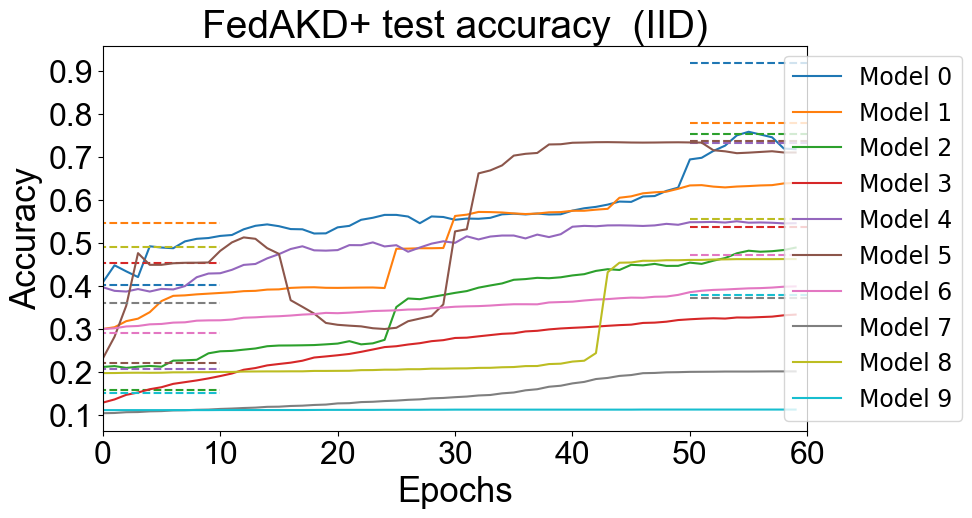

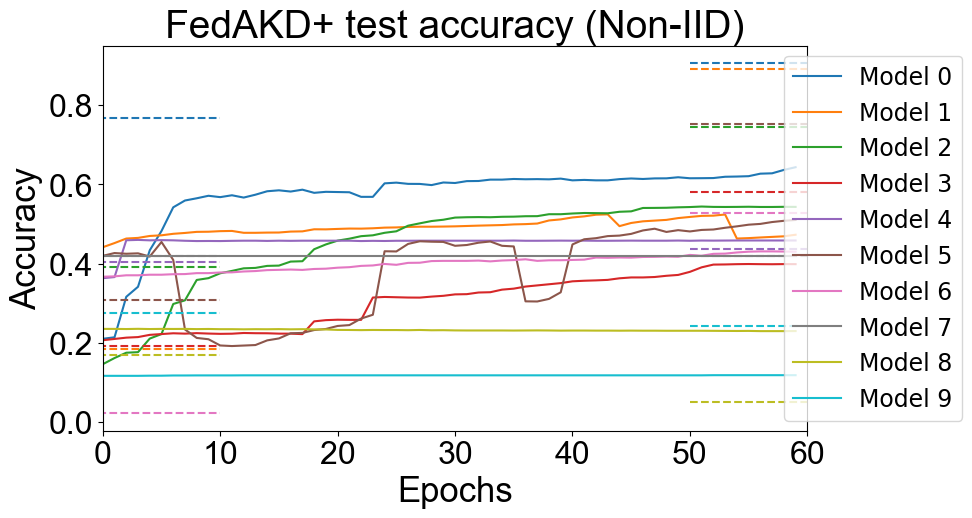

In [76]:
n_parties = 10 

exp = Experiment('results/exp_3')
last_local_accs_iid = exp.get_last_accuracies('local_train_iid')
last_local_accs_noniid = exp.get_last_accuracies('local_train_noniid')

last_central_accs_iid = exp.get_last_accuracies('central_train_iid')
last_central_accs_noniid = exp.get_last_accuracies('central_train_noniid')

fedAMD_iid = exp.get_accuracies('fedAMD_iid') 
fedAMD_noniid = exp.get_accuracies('fedAMD_noniid') 
# fedAMD_iid = exp.get_accuracies('fedMD_iid') 
# fedAMD_noniid = exp.get_accuracies('fedMD_noniid') 

# avg_left_iid, avg_right_iid = [np.mean(last_local_accs_iid)], [np.mean(last_central_accs_iid)]
# avg_left_noniid, avg_right_noniid = [np.mean(last_local_accs_noniid)], [np.mean(last_central_accs_noniid)]

smooth_center_iid = [smooth(np.mean(fedAMD_iid, axis = 0))]
smooth_center_noniid = [smooth(np.mean(fedAMD_noniid, axis = 0))]

center_iid = [np.mean(fedAMD_iid, axis = 0)]
center_noniid = [np.mean(fedAMD_noniid, axis = 0)]

fedAMD_noniid_limits = [np.min(fedAMD_noniid, axis = 0), np.max(fedAMD_noniid, axis = 0)]
fedAMD_iid_limits = [np.min(fedAMD_iid, axis = 0), np.max(fedAMD_iid, axis = 0)]


models_gains_iid = [int(round(fedAMD_iid[i].values[-1] - last_local_accs_iid[i], 2) *100) for i in range(len(last_local_accs_iid))]
models_gains_noniid = [int(round(fedAMD_noniid[i].values[-1] - last_local_accs_noniid[i], 2) *100) for i in range(len(last_local_accs_noniid))]
print('models gains iid:', models_gains_iid)
print('models gains noniid:', models_gains_noniid)

exp.plot_fedMD_like(last_local_accs_iid, fedAMD_iid, last_central_accs_iid, \
    labels = ['Model ' + str(i) for i in range(n_parties)],
     shades =None, 
     title = 'FedAKD+ test accuracy  (IID)' )

exp.plot_fedMD_like(last_local_accs_noniid, fedAMD_noniid, last_central_accs_noniid, \
    labels = ['Model ' + str(i)  for i in range(n_parties)],
     shades =None, 
     title = 'FedAKD+ test accuracy (Non-IID)')

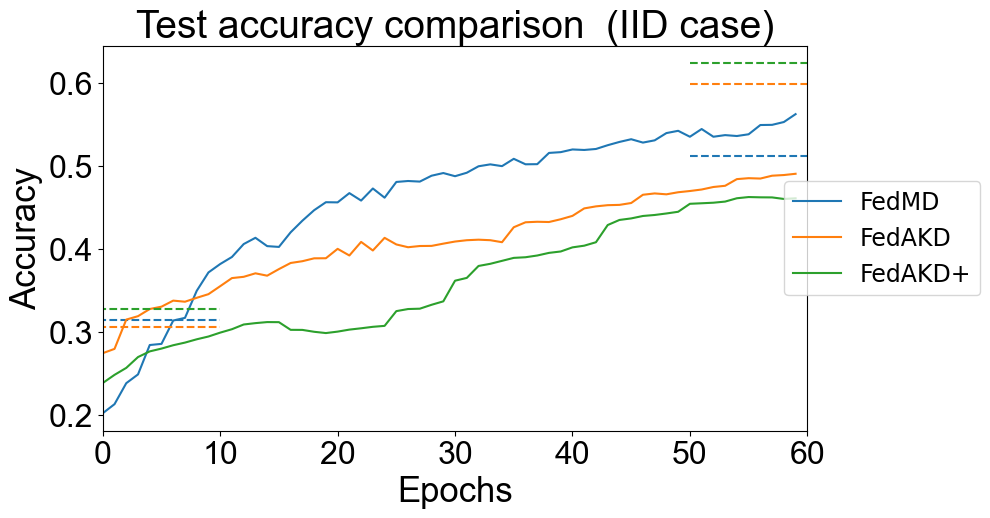

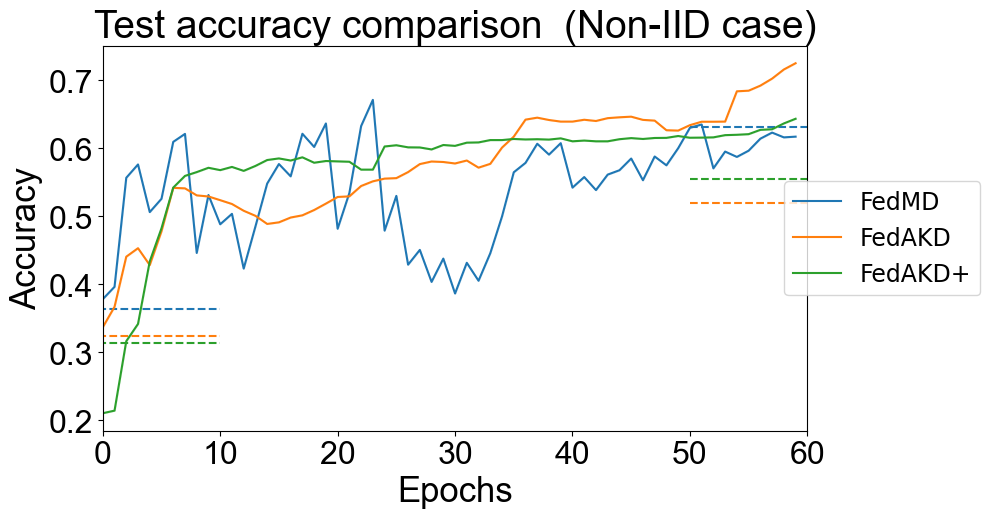

In [78]:
exp_dirs = ['results/exp_0', 'results/exp_1', 'results/exp_3']
exps = [Experiment(exp_dir) for exp_dir in exp_dirs]
exp_names = ['FedMD', 'FedAMD', 'FedAMD+']
exp_colors = ['tab:blue', 'tab:orange', 'tab:green']

last_local_acc_iids = [exp.get_last_accuracies('local_train_iid') for exp in exps]
last_local_acc_noniids = [exp.get_last_accuracies('local_train_noniid') for exp in exps]
avg_local_acc_iids = [np.mean(last_local_acc_iids[i]) for i in range(len(exps))]
avg_local_acc_noniids = [np.mean(last_local_acc_noniids[i]) for i in range(len(exps))]


last_central_acc_iids = [exp.get_last_accuracies('central_train_iid') for exp in exps]
last_central_acc_noniids = [exp.get_last_accuracies('central_train_noniid') for exp in exps]
avg_central_acc_iids = [np.mean(last_central_acc_iids[i]) for i in range(len(exps))]
avg_central_acc_noniids = [np.mean(last_central_acc_noniids[i]) for i in range(len(exps))]


fed_iids, fed_noniids = [], []
for exp in exps :
    if 'fedMD_iid' in os.listdir(exp.root) :
        fed_iids.append(exp.get_accuracies('fedMD_iid'))
        fed_noniids.append(exp.get_accuracies('fedMD_noniid'))
    elif 'fedAMD_iid' in os.listdir(exp.root) : 
        fed_iids.append(exp.get_accuracies('fedAMD_iid'))
        fed_noniids.append(exp.get_accuracies('fedAMD_noniid'))
    else : 
        raise ValueError('exp name {e} not recognized')

fed_len = min([len(fed_iids[i][0]) for i in range(len(exps))])
fed_iids = [[fed_iids[i][j][:fed_len] for j in range(len(fed_iids[i]))] for i in range(len(exps))]
fed_noniids = [[fed_noniids[i][0][:fed_len] for j in range(len(fed_noniids[i]))] for i in range(len(exps))]


smooth_fed_iids = [smooth(np.mean(fed_iid, axis = 0)) for fed_iid in fed_iids]
smooth_fed_noniids = [smooth(np.mean(fed_noniid, axis = 0)) for fed_noniid in fed_noniids]
fed_iid_limits = [[np.min(fed_iid, axis = 0), np.max(fed_iid, axis = 0)] for fed_iid in fed_iids]
fed_noniid_limits = [[np.min(fed_noniid, axis = 0), np.max(fed_noniid, axis = 0)] for fed_noniid in fed_noniids]


avg_fed_iid = [np.mean(fed_iid, axis = 0) for fed_iid in fed_iids]
avg_fed_noniids = [np.mean(fed_noniid, axis = 0) for fed_noniid in fed_noniids]

fed_iid_gains = [[int(round(fed_iids[i][j].values[-1] - last_local_acc_iids[i][j], 2) *100) for j in range(len(last_local_acc_iids[i]))] for i in range(len(exps))]
fed_noniid_gains = [[int(round(fed_noniids[i][j].values[-1] - last_local_acc_noniids[i][j], 2) *100) for j in range(len(last_local_acc_noniids[i]))] for i in range(len(exps))]



FL_methods =  ['FedMD', 'FedAKD', 'FedAKD+']


plot_fedMD_like_comparison(avg_local_acc_iids, avg_fed_iid, avg_central_acc_iids, labels = FL_methods, shades = None, title = 'Test accuracy comparison  (IID case)')
plot_fedMD_like_comparison(avg_local_acc_noniids, avg_fed_noniids, avg_central_acc_noniids, labels = FL_methods, shades = fed_noniid_limits, title = 'Test accuracy comparison  (Non-IID case)')


In [81]:


print("IID accuracy gains")
for name in exp_names : 
    print(name, ' accuracy:', round(avg_fed_iid[exp_names.index(name)][-1], 2), ' gains:', fed_iid_gains[exp_names.index(name)])
print() 

print("Non-IID accuracy gains")
for name in exp_names :
    print(name, ' accuracy:', round(avg_fed_noniids[exp_names.index(name)][-1], 2), ' gains:', fed_noniid_gains[exp_names.index(name)])


IID accuracy gains
FedMD  accuracy: 0.56  gains: [16, 33, 21, 31, 46, 39, 18, 15, 12, 15]
FedAMD  accuracy: 0.49  gains: [17, 45, 27, 21, 48, 16, 10, 18, -11, -6]
FedAMD+  accuracy: 0.46  gains: [31, 9, 33, -12, 34, 49, 11, -16, -3, -4]

Non-IID accuracy gains
FedMD  accuracy: 0.62  gains: [-6, 36, 27, 26, 18, 24, 32, 31, 42, 24]
FedAMD  accuracy: 0.73  gains: [10, 43, 46, 56, 25, 33, 55, 32, 40, 62]
FedAMD+  accuracy: 0.64  gains: [-12, 46, 25, 45, 24, 34, 62, 23, 47, 37]


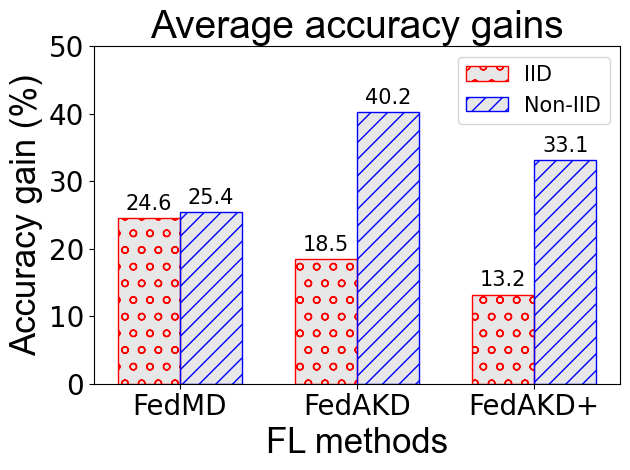

In [80]:




x = np.arange(len(FL_methods))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
colors = list(mcolors.TABLEAU_COLORS.keys())
avg_iid_gains = [np.mean(fed_iid_gains[i]) for i in range(len(exps))]
avg_noniid_gains = [np.mean(fed_noniid_gains[i]) for i in range(len(exps))]
rects1 = ax.bar(x - width/2, avg_iid_gains, width, label='IID', edgecolor = 'red', color=(0.1, 0.1, 0.1, 0.1), hatch = 'o')
rects2 = ax.bar(x + width/2, avg_noniid_gains, width, label='Non-IID', edgecolor = 'blue', color=(0.1, 0.1, 0.1, 0.1), hatch = '//')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('FL methods', **axis_font)
ax.set_ylabel('Accuracy gain (%)', **axis_font)

ax.set_title('Average accuracy gains',  **title_font)
ax.set_xticks(x, FL_methods)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_yticks(np.arange(0, 51, 10), fontsize = 8)
ax.legend(fontsize = 15)

ax.bar_label(rects1, padding=3, fontsize = 15)
ax.bar_label(rects2, padding=3, fontsize = 15)

ax.set_ylim(0, 50)
fig.tight_layout()

plt.show()

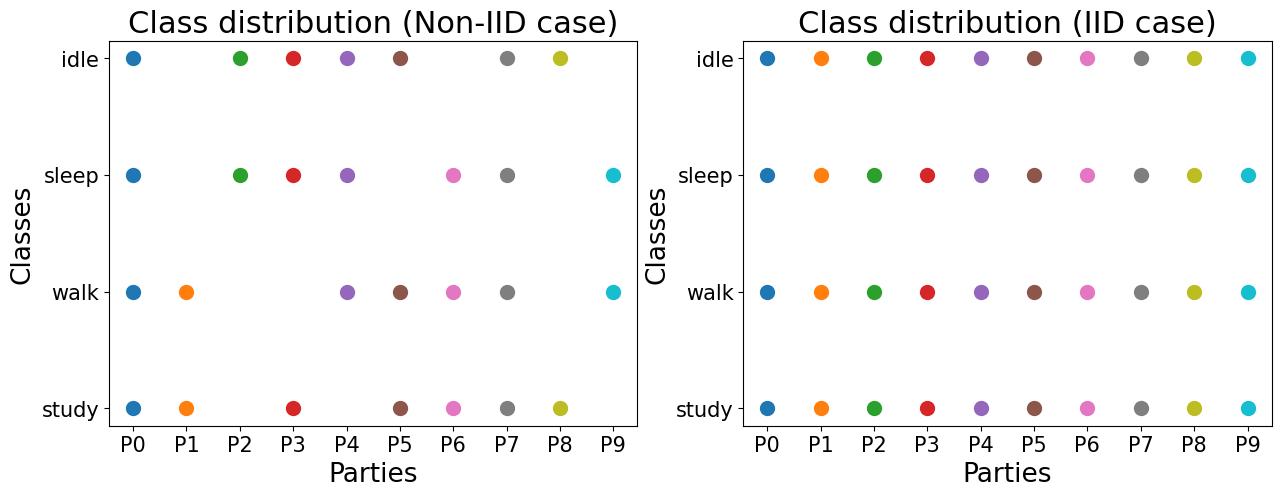

In [86]:
parties_classes = [
    [0, 1, 2, 3], 
    [0, 1], 
    [2, 3],
    [0, 2, 3],
    [1, 2, 3],
    [0, 1, 3],
    [0, 1, 2],
    [0, 1, 2, 3],
    [0, 3], 
    [1, 2]
]

# plot scatter plot of classes distribution
def plot_classes_distribution(parties_classes, title = None) :
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    colors = list(mcolors.TABLEAU_COLORS.keys())
    # plot non-iid case
    for i in range(len(parties_classes)) :
        axs[0].scatter([i] * len(parties_classes[i]), parties_classes[i], color = colors[i], s = 100)
    axs[0].set_title(title + ' (Non-IID case)', fontsize=22)
    axs[0].set_xlabel('Parties', fontsize=19)
    axs[0].set_ylabel('Classes', fontsize=19)
    axs[0].set_xticks(np.arange(len(parties_classes)), ['P' + str(i) for i in range(len(parties_classes))])
    axs[0].set_yticks(np.arange(4), [l for l in original_labels])
    axs[0].tick_params(axis='both', which='major', labelsize=15)

    
    # plot iid case
    n_classes = max(len(parties_classes[i]) for i in range(len(parties_classes)))
    for i in range(len(parties_classes)) :
        axs[1].scatter([i] * n_classes, np.arange(n_classes), color = colors[i], s = 100)
    axs[1].set_title(title + ' (IID case)', fontsize=22)
    axs[1].set_xlabel('Parties', fontsize=19)
    axs[1].set_ylabel('Classes', fontsize=19)
    axs[1].set_xticks(np.arange(len(parties_classes)), ['P' + str(i) for i in range(len(parties_classes))])
    axs[1].set_yticks(np.arange(4), [l for l in original_labels])
    axs[1].tick_params(axis='both', which='major', labelsize=15)
    plt.show()


plot_classes_distribution(parties_classes, title = 'Class distribution')


